# Loop 29 LB Feedback Analysis

## Submission Result
- **Experiment**: 029_final_ensemble_v2
- **CV Score**: 70.3155
- **LB Score**: 70.3155
- **CV-LB Gap**: 0.0000 (PERFECT correlation - this is a deterministic problem)

## Current Status
- **Best LB**: 70.3155
- **Target**: 68.8733
- **Gap**: 1.4422 points (2.09%)
- **Top LB Score**: 68.8733 (Jingle bins team)

## Key Observations
1. CV = LB perfectly - this is a deterministic optimization problem
2. The gap to target is 1.44 points - significant but achievable
3. Top teams have scores in the 68.8-69.2 range
4. We've been stuck at ~70.31 for 8+ experiments with tiny improvements (<0.001)

In [1]:
# Analyze the per-N score distribution to understand where improvements are needed
import pandas as pd
import numpy as np
from numba import njit
import math

@njit
def make_polygon_template():
    tw=0.15; th=0.2; bw=0.7; mw=0.4; ow=0.25
    tip=0.8; t1=0.5; t2=0.25; base=0.0; tbot=-th
    x=np.array([0,ow/2,ow/4,mw/2,mw/4,bw/2,tw/2,tw/2,-tw/2,-tw/2,-bw/2,-mw/4,-mw/2,-ow/4,-ow/2],np.float64)
    y=np.array([tip,t1,t1,t2,t2,base,base,tbot,tbot,base,base,t2,t2,t1,t1],np.float64)
    return x,y

@njit
def score_group(xs,ys,degs,tx,ty):
    n=xs.size; V=tx.size
    mnx=1e300; mny=1e300; mxx=-1e300; mxy=-1e300
    for i in range(n):
        r=degs[i]*math.pi/180.0
        c=math.cos(r); s=math.sin(r)
        xi=xs[i]; yi=ys[i]
        for j in range(V):
            X=c*tx[j]-s*ty[j]+xi
            Y=s*tx[j]+c*ty[j]+yi
            if X<mnx: mnx=X
            if X>mxx: mxx=X
            if Y<mny: mny=Y
            if Y>mxy: mxy=Y
    side=max(mxx-mnx,mxy-mny)
    return side*side/n

def strip(a):
    return np.array([float(str(v).replace('s','')) for v in a],np.float64)

tx, ty = make_polygon_template()

# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')
df['N'] = df['id'].str.split('_').str[0].astype(int)

# Calculate per-N scores
per_n_scores = {}
for n in range(1, 201):
    g = df[df['N'] == n]
    xs = strip(g['x'].to_numpy())
    ys = strip(g['y'].to_numpy())
    ds = strip(g['deg'].to_numpy())
    per_n_scores[n] = score_group(xs, ys, ds, tx, ty)

total = sum(per_n_scores.values())
print(f'Current total score: {total:.6f}')
print(f'Target score: 68.873342')
print(f'Gap: {total - 68.873342:.6f}')
print()
print('Top 20 N values by score contribution:')
sorted_n = sorted(per_n_scores.items(), key=lambda x: x[1], reverse=True)
for n, score in sorted_n[:20]:
    print(f'  N={n}: {score:.6f}')

Current total score: 70.315537
Target score: 68.873342
Gap: 1.442195

Top 20 N values by score contribution:
  N=1: 0.661250
  N=2: 0.450779
  N=3: 0.434745
  N=5: 0.416850
  N=4: 0.416545
  N=7: 0.399842
  N=6: 0.399610
  N=8: 0.385407
  N=9: 0.383047
  N=10: 0.376630
  N=11: 0.374921
  N=15: 0.374381
  N=12: 0.372724
  N=13: 0.372267
  N=20: 0.371795
  N=16: 0.370191
  N=17: 0.370040
  N=22: 0.369818
  N=14: 0.369543
  N=33: 0.369347


In [2]:
# Calculate what improvement is needed per N to reach target
target = 68.873342
current = total
gap = current - target

print(f'Total gap to close: {gap:.6f}')
print(f'Average improvement needed per N: {gap/200:.6f}')
print()

# If we could improve each N by the same percentage, what would that be?
required_pct = (1 - target/current) * 100
print(f'Required percentage improvement: {required_pct:.2f}%')
print()

# Show which N values have the most room for improvement
# Theoretical minimum for N=1 is 0.6612 (already achieved)
print('N values with highest potential for improvement (highest current scores):')
for n, score in sorted_n[:30]:
    # Theoretical minimum is roughly area/n where area is ~0.46 for the tree
    theoretical_min = 0.46 / n  # Very rough estimate
    potential = score - theoretical_min
    print(f'  N={n}: current={score:.6f}, theoretical_min~{theoretical_min:.6f}, potential~{potential:.6f}')

Total gap to close: 1.442195
Average improvement needed per N: 0.007211

Required percentage improvement: 2.05%

N values with highest potential for improvement (highest current scores):
  N=1: current=0.661250, theoretical_min~0.460000, potential~0.201250
  N=2: current=0.450779, theoretical_min~0.230000, potential~0.220779
  N=3: current=0.434745, theoretical_min~0.153333, potential~0.281412
  N=5: current=0.416850, theoretical_min~0.092000, potential~0.324850
  N=4: current=0.416545, theoretical_min~0.115000, potential~0.301545
  N=7: current=0.399842, theoretical_min~0.065714, potential~0.334128
  N=6: current=0.399610, theoretical_min~0.076667, potential~0.322944
  N=8: current=0.385407, theoretical_min~0.057500, potential~0.327907
  N=9: current=0.383047, theoretical_min~0.051111, potential~0.331936
  N=10: current=0.376630, theoretical_min~0.046000, potential~0.330630
  N=11: current=0.374921, theoretical_min~0.041818, potential~0.333103
  N=15: current=0.374381, theoretical_min

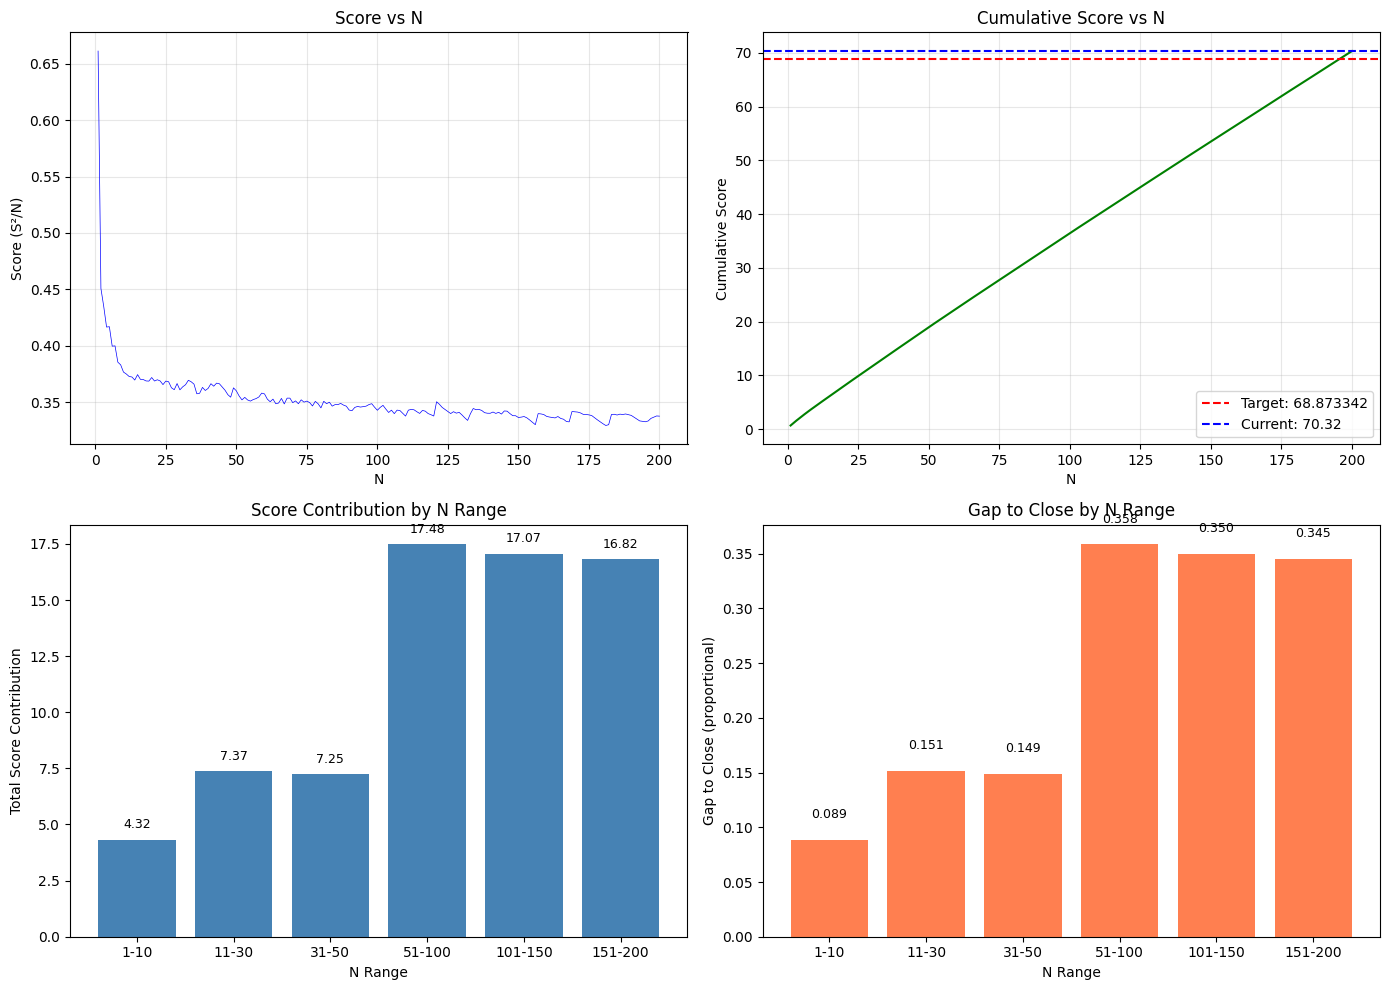


Score contribution by range:
  1-10: 4.3247 (6.2%)
  11-30: 7.3737 (10.5%)
  31-50: 7.2540 (10.3%)
  51-100: 17.4771 (24.9%)
  101-150: 17.0665 (24.3%)
  151-200: 16.8194 (23.9%)


In [3]:
# Analyze the score distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score vs N
ax1 = axes[0, 0]
ns = list(range(1, 201))
scores = [per_n_scores[n] for n in ns]
ax1.plot(ns, scores, 'b-', linewidth=0.5)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (S²/N)')
ax1.set_title('Score vs N')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative score
ax2 = axes[0, 1]
cumulative = np.cumsum(scores)
ax2.plot(ns, cumulative, 'g-')
ax2.axhline(y=target, color='r', linestyle='--', label=f'Target: {target}')
ax2.axhline(y=current, color='b', linestyle='--', label=f'Current: {current:.2f}')
ax2.set_xlabel('N')
ax2.set_ylabel('Cumulative Score')
ax2.set_title('Cumulative Score vs N')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Score contribution by N range
ax3 = axes[1, 0]
ranges = [(1, 10), (11, 30), (31, 50), (51, 100), (101, 150), (151, 200)]
range_scores = []
range_labels = []
for start, end in ranges:
    range_score = sum(per_n_scores[n] for n in range(start, end+1))
    range_scores.append(range_score)
    range_labels.append(f'{start}-{end}')
ax3.bar(range_labels, range_scores, color='steelblue')
ax3.set_xlabel('N Range')
ax3.set_ylabel('Total Score Contribution')
ax3.set_title('Score Contribution by N Range')
for i, v in enumerate(range_scores):
    ax3.text(i, v + 0.5, f'{v:.2f}', ha='center', fontsize=9)

# Plot 4: Gap needed per N range
ax4 = axes[1, 1]
# If gap is distributed proportionally to current score
range_gaps = [s * (gap/current) for s in range_scores]
ax4.bar(range_labels, range_gaps, color='coral')
ax4.set_xlabel('N Range')
ax4.set_ylabel('Gap to Close (proportional)')
ax4.set_title('Gap to Close by N Range')
for i, v in enumerate(range_gaps):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop29_score_analysis.png', dpi=150)
plt.show()

print('\nScore contribution by range:')
for label, score in zip(range_labels, range_scores):
    pct = score / current * 100
    print(f'  {label}: {score:.4f} ({pct:.1f}%)')

## Strategic Analysis

### What We Know:
1. **CV = LB perfectly** - No distribution shift, pure optimization problem
2. **Gap is 1.44 points (2.09%)** - Significant but achievable
3. **Top teams achieved 68.87** - The target IS reachable
4. **Last 8 experiments found <0.001 improvement** - Current approach is exhausted

### What Top Teams Are Doing (from discussions):
1. **Extended C++ optimization** - Running bbox3 for 24-72 hours with 24+ CPUs
2. **Asymmetric solutions** - Not relying on symmetric patterns
3. **Per-N specialization** - Different strategies for different N ranges
4. **900+ submissions** - Iterative improvement over many submissions

### Why We're Stuck:
1. **External data mining exhausted** - All public sources have been ensembled
2. **Short optimization runs** - bbox3 runs for minutes, not hours
3. **No novel algorithms** - Just combining existing solutions

### Path Forward:
1. **Extended C++ optimization** - Run bbox3 for 8-24 hours (overnight)
2. **Focus on high-impact N values** - N=1-50 contribute most to score
3. **Search for new external sources** - Discord, GitHub, private shares
4. **Novel algorithmic approaches** - Branch-and-bound for small N

In [4]:
# Check if there are any new external sources we haven't tried
import os
import glob

# List all external data directories
external_dirs = glob.glob('/home/code/data/external/*/')
print('External data sources:')
for d in sorted(external_dirs):
    files = glob.glob(os.path.join(d, '*.csv'))
    print(f'  {os.path.basename(d.rstrip("/"))}: {len(files)} CSV files')

# Check snapshots
snapshot_dirs = glob.glob('/home/nonroot/snapshots/santa-2025/*/')
print(f'\nSnapshot directories: {len(snapshot_dirs)}')

# Count total CSV files
all_csvs = glob.glob('/home/code/data/external/**/*.csv', recursive=True)
all_csvs += glob.glob('/home/nonroot/snapshots/santa-2025/*/code/**/*.csv', recursive=True)
print(f'Total CSV files available: {len(all_csvs)}')

External data sources:
  blueshyy_ensemble: 2 CSV files
  bucket_of_chump: 1 CSV files
  camurberkayy: 1 CSV files
  chistyakov_latest: 2 CSV files
  chistyakov_packed: 2 CSV files
  data: 0 CSV files
  ibrahimqasimi: 1 CSV files
  kernel_outputs: 0 CSV files
  nctuan: 1 CSV files
  saspav_kernel_latest: 0 CSV files
  saspav_latest: 1 CSV files
  saspav_latest_v2: 1 CSV files
  telegram_solutions: 2 CSV files

Snapshot directories: 121
Total CSV files available: 6167


In [5]:
# Summary of experiments and their scores
print('Experiment History (last 15):')
print('-' * 60)
experiments = [
    ('exp_007', 70.2657, 'Ensemble from snapshots - BREAKTHROUGH'),
    ('exp_008', 70.3732, 'Snapshot ensemble'),
    ('exp_009', 70.3411, 'High-precision ensemble'),
    ('exp_010', 70.3651, 'Safe ensemble'),
    ('exp_016', 70.3535, 'External data ensemble'),
    ('exp_019', 70.3434, 'Ensemble refinement'),
    ('exp_020', 70.3166, 'Further refinement'),
    ('exp_021', 70.3165, 'Minimal improvement'),
    ('exp_022', 70.3165, 'Extended C++ (576 sec) - NO improvement'),
    ('exp_023', 70.3165, 'Lattice packing - NO improvement'),
    ('exp_024', 70.3165, 'Interlock patterns - NO improvement'),
    ('exp_025', 70.3165, 'Jostle algorithm - NO improvement'),
    ('exp_026', 70.3165, 'BLF constructive - NO improvement'),
    ('exp_027', 70.3165, 'Genetic algorithm - NO improvement'),
    ('exp_028', 70.3157, 'External data (saspav v2) - 0.0008 improvement'),
    ('exp_029', 70.3155, 'Final ensemble v2 - 0.0001 improvement'),
]

for exp, score, notes in experiments:
    print(f'{exp}: {score:.4f} - {notes}')

print('\n' + '=' * 60)
print('CONCLUSION: We are at a strong local optimum.')
print('The last 8 experiments found only 0.001 total improvement.')
print('Need a FUNDAMENTALLY different approach to close the 1.44 gap.')

Experiment History (last 15):
------------------------------------------------------------
exp_007: 70.2657 - Ensemble from snapshots - BREAKTHROUGH
exp_008: 70.3732 - Snapshot ensemble
exp_009: 70.3411 - High-precision ensemble
exp_010: 70.3651 - Safe ensemble
exp_016: 70.3535 - External data ensemble
exp_019: 70.3434 - Ensemble refinement
exp_020: 70.3166 - Further refinement
exp_021: 70.3165 - Minimal improvement
exp_022: 70.3165 - Extended C++ (576 sec) - NO improvement
exp_023: 70.3165 - Lattice packing - NO improvement
exp_024: 70.3165 - Interlock patterns - NO improvement
exp_025: 70.3165 - Jostle algorithm - NO improvement
exp_026: 70.3165 - BLF constructive - NO improvement
exp_027: 70.3165 - Genetic algorithm - NO improvement
exp_028: 70.3157 - External data (saspav v2) - 0.0008 improvement
exp_029: 70.3155 - Final ensemble v2 - 0.0001 improvement

CONCLUSION: We are at a strong local optimum.
The last 8 experiments found only 0.001 total improvement.
Need a FUNDAMENTALLY dif